In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv('../input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv')
df.head()

/kaggle/input/churn-in-telecoms-dataset/bigml_59c28831336c6604c800002a.csv


,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [2]:
# df.info()

## Целевой признак — churn, который говорит о том, покинет ли клиент телефонную компанию. Рассматривается задача классификации.

In [3]:
df.churn.value_counts()

False    2850
True      483
Name: churn, dtype: int64

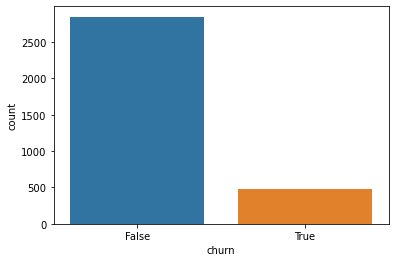

In [4]:
sns.countplot(df['churn'])

### Случаев, когда человек остается клиентом компании гораздо больше, чем обратных.

In [5]:
# df = df.join(pd.get_dummies(df['state']))
# После создания дополнительных признаков на основе столбца 'state' accuracy понижается.

In [6]:
states = df.state.unique()
states_num = {}
for i in range(len(states)):
    states_num[states[i]] = i
df['states_num'] = df['state'].map(states_num)

In [7]:
df.drop('state', axis=1, inplace=True)

df['churn_'] = df['churn'].map({True: 1, False: 0})
df.drop('churn', axis=1, inplace=True)

df['international_plan'] = df['international plan'].map({'yes': 1, 'no': 0})
df.drop('international plan', axis=1, inplace=True)

df['voice_mail_plan'] = df['voice mail plan'].map({'yes': 1, 'no': 0})
df.drop('voice mail plan', axis=1, inplace=True)

df.drop('phone number', axis=1, inplace=True)

In [8]:
# df.info()

In [9]:
y = df['churn_']
X = df.drop(labels = ['churn_'],axis = 1) 

In [10]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
scaler.mean_
X_new = scaler.transform(X)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_new, 
                                                      y, 
                                                      test_size=0.3, 
                                                      random_state=19)

In [12]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_valid)

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(y_valid, y_pred)

0.878

In [14]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)
scores = cross_val_score(knn, X_new, y, 
                         cv=kf, scoring='accuracy')
mean_score = scores.mean()
mean_score

0.8862888375632003

In [15]:
from sklearn.model_selection import GridSearchCV
knn_params = {'n_neighbors': np.arange(1, 51)}
knn_grid = GridSearchCV(knn, 
                        knn_params, 
                        scoring='accuracy',
                        cv=kf)
knn_grid.fit(X_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])},
             scoring='accuracy')

In [16]:
knn_grid.best_score_

0.8808337392359228

In [17]:
knn_grid.best_params_

{'n_neighbors': 5}

In [18]:
score_df = pd.DataFrame(knn_grid.cv_results_)
# score_df.head()

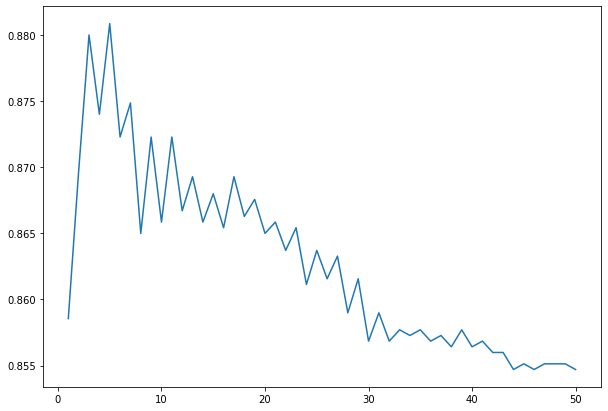

In [19]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(score_df['param_n_neighbors'], score_df['mean_test_score'])

In [20]:
p = np.linspace(1,10,200)
p_dict ={}
max_acc = 0
for val in p:
    knn = KNeighborsClassifier(n_neighbors=5, p=val, metric='minkowski', weights='distance')
    scores = cross_val_score(knn, X_new, y, 
                         cv=kf, scoring='accuracy')
    mean_score = scores.mean()
    if mean_score > max_acc:
        max_acc = mean_score
        max_acc_str = 'p = {}:   accuracy = {}'.format(val, max_acc)
    p_dict[val] = mean_score
    
max_acc_str

'p = 1.678391959798995:   accuracy = 0.8889879384632009'

In [21]:
from sklearn.neighbors import NearestCentroid
clf = NearestCentroid()
clf.fit(X_train, y_train)
scores = cross_val_score(knn, X_new, y, 
                         cv=kf, scoring='accuracy')
mean_score = scores.mean()
mean_score

0.8736888312600456

In [22]:
from sklearn.neighbors import RadiusNeighborsClassifier
neigh = RadiusNeighborsClassifier(radius=1.0)
neigh.fit(X_train, y_train)
scores = cross_val_score(knn, X_new, y, 
                         cv=kf, scoring='accuracy')
mean_score = scores.mean()
mean_score

0.8736888312600456